In [129]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import pandas as pd 
import requests
import json
import time
from konlpy.tag import Okt
from ckonlpy.tag import Twitter
from collections import Counter
from wordcloud import WordCloud
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [73]:
driver = webdriver.Chrome("C:\\chromedriver.exe")

In [74]:
url = "http://www.chungnam.go.kr/coronaStatus.do"

In [75]:
driver.get(url)

In [76]:
bs = BeautifulSoup(driver.page_source, "html.parser") 
bs

<html lang="ko"><head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width,initial-scale=1.0,maximum-scale=1.0,minimum-scale1.0,user-scalable=no" name="viewport"/>
<meta content="telephone=no,email=no,address=no" name="format-detection"/>
<meta content="충남도청" name="author"/>
<meta content="충남도청, 충청남도청, 충남, 충청남도, 더 행복한 충남 대한민국의 중심" name="Keywords"/>
<meta content="더 행복한 충남 대한민국의 중심, 충청남도 홈페이지에 오신 것을 환영합니다." name="description"/>
<meta content="충청남도 홍성군 홍북읍 충남대로 21, 대표전화 041-120" name="copyright"/>
<title>충청남도 코로나19 발생현황</title>
<link href="/css/corona/corona19_new.css" rel="stylesheet" type="text/css"/>
<link href="/css/cnportal/responsive/font.css" rel="stylesheet"/>
<script src="https://adlc-exchange.toast.com/getid?callback=_AceSync.CB"></script><script src="http://cr.acecounter.com/Web/AceCounter_AW.js?gc=AM3A33173330568&amp;py=0&amp;gd=gtp9&amp;gp=8080&amp;up=NaPm_Ncisy&amp;rd=1583376456427"></script><script src="/script/j

In [77]:
#데이터프레임 생성
columns=['환자','인적사항','감염경로','확진일','접촉자수','격리시설','이동경로']
df=pd.DataFrame(columns=columns)

In [78]:
datas=bs.find_all('td')

In [79]:
d_text=[]
for data in datas:
    d_text.append(data.get_text())
d_text

['충남#88(천안#80)',
 '천안, 여, 6세',
 '역학조사중',
 '3월 5일',
 '역학조사중',
 '확인중',
 '\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천안시서북구보건소 선별진료소에서 검체 체취, 3.5.(목) 확진 판정\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 역학조사 中\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t\t\xa0\n\t\t\t\t\t\t\t\t\t\t\t\t',
 '충남#87(천안#79)',
 '천안, 남, 12세',
 '역학조사중',
 '3월 5일',
 '역학조사중',
 '확인중',
 '\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천안시서북구보건소 선별진료소에서 검체 체취, 3.5.(목) 확진 판정\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 역학조사 中\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t\t\xa0\n\t\t\t\t\t\t\t\t\t\t\t\t',
 '충남#86(천안#78)',
 '천안, 여, 39세',
 '역학조사중',
 '3월 5일',
 '역학조사중',
 '확인중',
 '\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천안시서북구보건소 선별진료소에서 검체 체취, 3.5.(목) 확진 판정\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 역학조사 中\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t\t\xa0\n\t\t\t\t\t\t\t\t\t\t\t\t',
 '충남#85(천안#77)',
 '천안, 여, 48세',
 '역학조사중',
 '3월 4일',
 '역학조사중',
 '확인중',
 '\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.27.(목) 인후통, 가래 증상, 천안시서북구보건소 선별진료소에서 검체 체취, 3.4.(수) 확진 판정\n\t\t

In [80]:
#def make_list(text,a_list):
n=0
환자=[]
인적사항,감염경로,확진일,접촉자수,격리시설,이동경로=[],[],[],[],[],[]

for text in d_text:
    n+=1
    if n%7==1:
        환자.append(text)
    elif n%7==2:
        인적사항.append(text)
    elif n%7==3:
        감염경로.append(text)
    elif n%7==4:
        확진일.append(text)
    elif n%7==5:
        접촉자수.append(text)
    elif n%7==6:
        격리시설.append(text)
    else :
        이동경로.append(text)
        


In [81]:
i=0
title=[환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로]
for column in columns:
    df[column]=title[i]
    i+=1
df

,환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로
0,충남#88(천안#80),"천안, 여, 6세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천..."
1,충남#87(천안#79),"천안, 남, 12세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천..."
2,충남#86(천안#78),"천안, 여, 39세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천..."
3,충남#85(천안#77),"천안, 여, 48세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.27.(목) 인후통, 가래..."
4,충남#84(천안#76),"천안, 남, 39세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.25.(화) 인후통 증상,..."
...,...,...,...,...,...,...,...
83,충남#5(천안#4),"천안(불당동), 여, 44세",역학조사중,2월 26일,9명,천안의료원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.23. 발열, 2.24.(..."
84,충남#4(천안#3),"천안(불당동), 여, 47세",역학조사중,2월 25일,5명,천안 단국대학교병원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.20. 발병, 2.24.(..."
85,충남#3(천안#2),"천안(두정동), 여, 50세",역학조사중,2월 25일,4명,천안 단국대학병원,\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.24.(02:30경) 발열...
86,충남#2(천안#1),"천안(불당동), 여, 47대",역학조사중,2월 25일,36명,천안 단국대학병원,\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2월 24일(16:00) 발열...


In [82]:
#열 추가
#df=df.append({'지역':'','성별':'','나이':''},ignore_index=True)

In [83]:
HR=df['인적사항'].str.replace(',','').astype(str)

HR.dtypes

area,gender,age=[],[],[]
for hr in HR:
    hr_split=hr.split()
    area.append(hr_split[0])
    gender.append(hr_split[1])
    age.append(hr_split[2])

df['나이']=age
df['지역']=area
df['성별']=gender



In [84]:
df

,환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로,나이,지역,성별
0,충남#88(천안#80),"천안, 여, 6세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",6세,천안,여
1,충남#87(천안#79),"천안, 남, 12세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",12세,천안,남
2,충남#86(천안#78),"천안, 여, 39세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",39세,천안,여
3,충남#85(천안#77),"천안, 여, 48세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.27.(목) 인후통, 가래...",48세,천안,여
4,충남#84(천안#76),"천안, 남, 39세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.25.(화) 인후통 증상,...",39세,천안,남
...,...,...,...,...,...,...,...,...,...,...
83,충남#5(천안#4),"천안(불당동), 여, 44세",역학조사중,2월 26일,9명,천안의료원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.23. 발열, 2.24.(...",44세,천안(불당동),여
84,충남#4(천안#3),"천안(불당동), 여, 47세",역학조사중,2월 25일,5명,천안 단국대학교병원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.20. 발병, 2.24.(...",47세,천안(불당동),여
85,충남#3(천안#2),"천안(두정동), 여, 50세",역학조사중,2월 25일,4명,천안 단국대학병원,\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.24.(02:30경) 발열...,50세,천안(두정동),여
86,충남#2(천안#1),"천안(불당동), 여, 47대",역학조사중,2월 25일,36명,천안 단국대학병원,\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2월 24일(16:00) 발열...,47대,천안(불당동),여


In [85]:
#환자, 대분류 소분류 나누기
ID=df['환자'].str.replace(')','').astype(str)

ID.dtypes

High,Low=[],[]
for id in ID:
    id_split=id.split('(')
    High.append(id_split[0])
    Low.append(id_split[1])


df['대분류']=High
df['소분류']=Low



In [86]:
df

,환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로,나이,지역,성별,대분류,소분류
0,충남#88(천안#80),"천안, 여, 6세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",6세,천안,여,충남#88,천안#80
1,충남#87(천안#79),"천안, 남, 12세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",12세,천안,남,충남#87,천안#79
2,충남#86(천안#78),"천안, 여, 39세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",39세,천안,여,충남#86,천안#78
3,충남#85(천안#77),"천안, 여, 48세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.27.(목) 인후통, 가래...",48세,천안,여,충남#85,천안#77
4,충남#84(천안#76),"천안, 남, 39세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.25.(화) 인후통 증상,...",39세,천안,남,충남#84,천안#76
...,...,...,...,...,...,...,...,...,...,...,...,...
83,충남#5(천안#4),"천안(불당동), 여, 44세",역학조사중,2월 26일,9명,천안의료원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.23. 발열, 2.24.(...",44세,천안(불당동),여,충남#5,천안#4
84,충남#4(천안#3),"천안(불당동), 여, 47세",역학조사중,2월 25일,5명,천안 단국대학교병원,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.20. 발병, 2.24.(...",47세,천안(불당동),여,충남#4,천안#3
85,충남#3(천안#2),"천안(두정동), 여, 50세",역학조사중,2월 25일,4명,천안 단국대학병원,\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.24.(02:30경) 발열...,50세,천안(두정동),여,충남#3,천안#2
86,충남#2(천안#1),"천안(불당동), 여, 47대",역학조사중,2월 25일,36명,천안 단국대학병원,\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2월 24일(16:00) 발열...,47대,천안(불당동),여,충남#2,천안#1


In [87]:

#rout=df['이동경로'].tolist()
rout=df['이동경로'].str.replace('\t','').astype(str)
#rout=rout.str.replace('\n','').astype(str)
rout=rout.str.replace('\xa0','').astype(str)
rout=rout.str.replace('피트니스','휘트니스').astype(str)
rout=rout.str.replace('천안시','천안').astype(str)
rout=rout.str.replace('아산시','아산').astype(str)
rout_list=rout.tolist() #이동경로 데이터프레임 리스트로 변환

In [88]:
rout_list

['\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5.(목) 확진 판정\n- 역학조사 中\n\n\n',
 '\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5.(목) 확진 판정\n- 역학조사 中\n\n\n',
 '\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5.(목) 확진 판정\n- 역학조사 中\n\n\n',
 '\n- 2.27.(목) 인후통, 가래 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.4.(수) 확진 판정\n- 역학조사 中\n\n\n',
 '\n- 2.25.(화) 인후통 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.4.(수) 확진 판정\n- 역학조사 中\n\n\n',
 '\n- 2. 24.(월) 기침, 가래 증상, 천안동남구보건소 선별진료소에서 검체 채취, 3.4. 확진 판정\n- 거주지 : 백석동 주공그린빌 1단지, 충남#6번(아산#1번) 확진자(대타강사 1회, 강습 50분)로부터 1회 수업 받음, 역학조사 中\n\n2.22.(토) 15:25-15:30 백석동 보드웰카페 이동/도보/마스크O\n2.22.(토) 15:30-20:00 카페에서 프로젝트 작업/마스크O(음식물 섭취 시 미착용)⇒ 접촉자 1명\n2.22.(토) 20:00-20:05 집으로 이동/도보/마스크O\n2.23.(일) 13:30-23:00 백석동 보드웰카페/도보이동/마스크O ⇒ 접촉자 1명\n2.23.(일) 23:00-23:05 집으로 이동/도보/마스크O\n2.24.(월) 집에 머무름\n2.25.(화) 15:40-15:50 롯데리아 백석점으로 이동/도보/마스크O\n2.25.(화) 15:50-22:00 롯데리아 백석점(아르바이트)/마스크O ⇒ 접촉자 2명\n2.25.(화) 22:00- 22:10 귀가/도보/마스크O\n2.26.(수) 15:40-15:50 롯데리아 백석점으로 이동/도보/마스크O\n2.26.(수) 15:50-21:40 롯데리아 백석점(아르바이트)/마스크O ⇒

In [89]:
df['이동경로_편집']=rout_list

In [90]:
df.head()

,환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로,나이,지역,성별,대분류,소분류,이동경로_편집
0,충남#88(천안#80),"천안, 여, 6세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",6세,천안,여,충남#88,천안#80,"\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5..."
1,충남#87(천안#79),"천안, 남, 12세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",12세,천안,남,충남#87,천안#79,"\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5..."
2,충남#86(천안#78),"천안, 여, 39세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",39세,천안,여,충남#86,천안#78,"\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5..."
3,충남#85(천안#77),"천안, 여, 48세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.27.(목) 인후통, 가래...",48세,천안,여,충남#85,천안#77,"\n- 2.27.(목) 인후통, 가래 증상, 천안서북구보건소 선별진료소에서 검체 체..."
4,충남#84(천안#76),"천안, 남, 39세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.25.(화) 인후통 증상,...",39세,천안,남,충남#84,천안#76,"\n- 2.25.(화) 인후통 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3..."


In [91]:
#워드클라우드 분석
text=''.join(rout_list)

twitter=Twitter()
twitter.add_dictionary(['확진자','휘트니스','도보이동','쌍용동','동일하이빌','선별진료소','천안충무병원','하나로마트','자차이동','인후통','롯데마트','삼성라온내과','성정동','M정밀'], 'Noun') # 사전에 단어추가


nouns=twitter.nouns(text)

# 길이 하나 이상인 형태소만 리스트 담기
nouns=[n for n in nouns if len(n)>1]


# 불용어 처리
stop_words=''
stop_words=stop_words.split(' ')

filter_nouns=[n for n in nouns if n not in stop_words]        
        
# 명사만 빈도수 추출(상위 100개)
count=Counter(filter_nouns)
tags=count.most_common(100)

print(tags)


[('천안', 383), ('접촉', 242), ('마스크', 193), ('선별진료소', 149), ('자택', 147), ('보건소', 124), ('귀가', 106), ('착용', 101), ('서북구', 98), ('판정', 97), ('확진', 96), ('조사', 96), ('검체', 90), ('아산', 88), ('거주지', 80), ('역학', 77), ('체취', 75), ('불당동', 71), ('거주', 69), ('증상', 66), ('확진자', 66), ('자차', 62), ('수강생', 49), ('검사', 47), ('직원', 44), ('도보', 38), ('가족', 36), ('성정동', 35), ('약국', 33), ('종일', 32), ('동남구', 29), ('충남', 29), ('자차이동', 29), ('쌍용동', 28), ('백석', 26), ('식당', 26), ('휘트니스', 25), ('정동', 23), ('출근', 23), ('불당', 23), ('기타', 22), ('백석동', 22), ('이동', 21), ('인후통', 20), ('센터', 20), ('격리', 20), ('병원', 20), ('쌍용', 20), ('자가', 19), ('단지', 18), ('방문', 18), ('채취', 16), ('발열', 16), ('근무', 16), ('남편', 16), ('부산', 16), ('버스', 15), ('순천향대', 15), ('마트', 15), ('천안의료원', 15), ('동료', 15), ('가래', 14), ('도보이동', 14), ('무증상', 14), ('아이파크', 14), ('새마을금고', 14), ('자녀', 14), ('아파트', 14), ('식사', 13), ('발병', 13), ('지점', 13), ('M정밀', 12), ('푸르지오', 11), ('기침', 10), ('도착', 10), ('외부', 10), ('지인', 10), ('이용', 10), ('추가', 10), ('천안충무병

In [92]:
for t in rout_list:
    if "정밀" in t:
        print(t)


- 2.28.(금) 가래 증상, 천안동남구보건소 선별진료소에서 검체 체취, 2.29 확진 판정
- 2월 29일 역학조사 中(* 천안 #21번 확진자의 가족, 거주지 : 영성동 펜타폴리스)

2.25(화) 07:00 ㈜M정밀 출근(아산) -자차이동,마스크착용,직원2명접촉
2.25(화) 11:30 하나로부페식당(아산)-자차이동,마스크착용,직원2명.식당주인 접촉
2.25(화) 12:10 ㈜M정밀 근무
2.25(화) 17:30 하나로부페식당(아산)-자차이동,마스크착용,직원2명.식당주인 접촉
2.25(화) 18:50 ㈜M정밀 근무-자차이동,마스크착용
2.25(화) 21:00 자택 귀가-자차이동,마스크착용
2.26(수) 07:00 ㈜M정밀 출근(아산)-자차이동,마스크착용,직원2명접촉
2.26(수) 11:30 하나로부페식당(아산)-자차이동,마스크착용,직원2명.식당주인 접촉
2.26(수) 12:10 ㈜M정밀 근무
2.26(수) 17:30 하나로부페식당(아산)-자차이동,마스크착용,직원2명.식당주인 접촉
2.26(수) 18:50 ㈜M정밀 근무-자차이동,마스크착용
2.26(수) 21:00 자택 귀가-자차이동,마스크착용
2.27(목) 07:00 ㈜M정밀 출근(아산)-자차이동,마스크착용,직원2명접촉
2.27(목) 07:30 하나로부페식당(아산)-자차이동,마스크착용,직원2명.식당주인 접촉
2.27(목) 12:10 ㈜M정밀 근무
2.27(목) 17:30 하나로부페식당(아산)-자차이동,마스크착용,직원2명.식당주인 접촉
2.27(목) 18:50 ㈜M정밀 근무-자차이동,마스크착용
2.27(목) 21:10 GS25아산산동점-자차이동,마스크착용, 직원1명(마스크착용) 접촉
 자택거주-자차이동,마스크착용
2.28(금) 07:00 ㈜M정밀 출근(아산) -자차이동,마스크착용,직원2명접촉
2.28(금) 11:30 하나로부페식당(아산)-자차이동,마스크착용,직원2명.식당주인 접촉
2.28(금)12:10 ㈜M정밀 근무
2.28(금) 17:30 하나로부페식당(아산)-자차이동,마스크착용,직원2명.식당주인 접촉

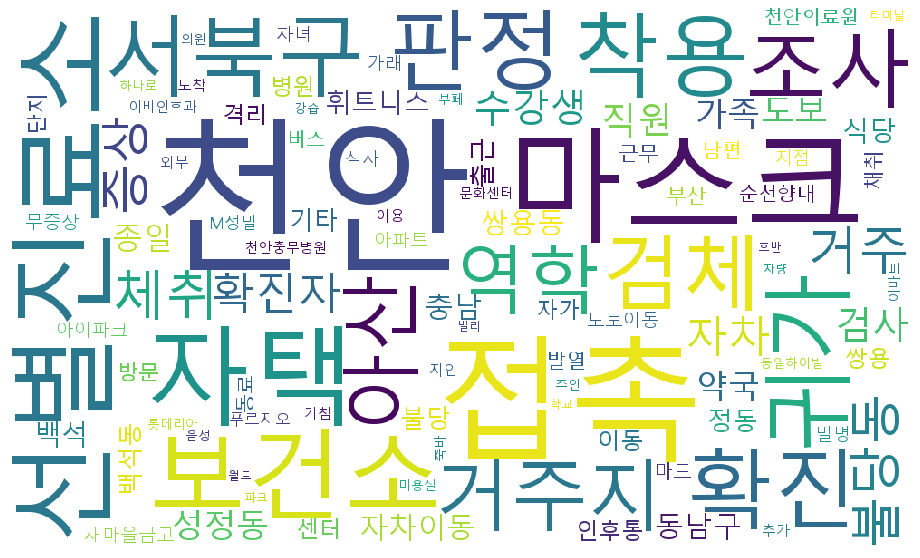

In [93]:
#워드클라우드 그리기

wordcloud=WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',background_color='white',width=1000,height=600).generate_from_frequencies(dict(tags))

fig=plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

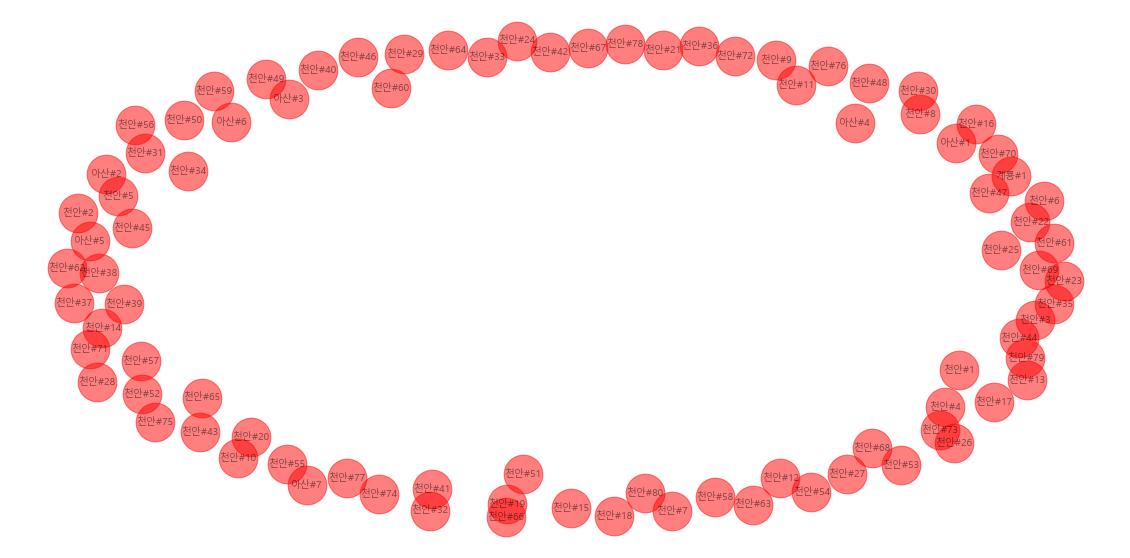

In [118]:
#네트워크 분석으로 연관점 찾기
# http://blog.daum.net/geoscience/1408 참조


#font_path="c:/Windows/Fonts/malgun.ttf"
#font_name=fm.FontProperties(fname=font_path).get_name()
#rc=('font', font_family=font_name)

plt.figure(figsize=(20,10))
plt.axis('off')
G=nx.Graph()
pos=nx.random_layout(G)
#pos=nx.planar_layout(G)
#pos=nx.spring_layout(G)
#G.add_edge(1,2)
G.add_nodes_from(df.소분류)
#G.nodes()
nx.draw_networkx(G, node_size=1500, font_size=10, font_family=font_name, node_color='R',alpha=0.5)#, with_lables=True
plt.show()

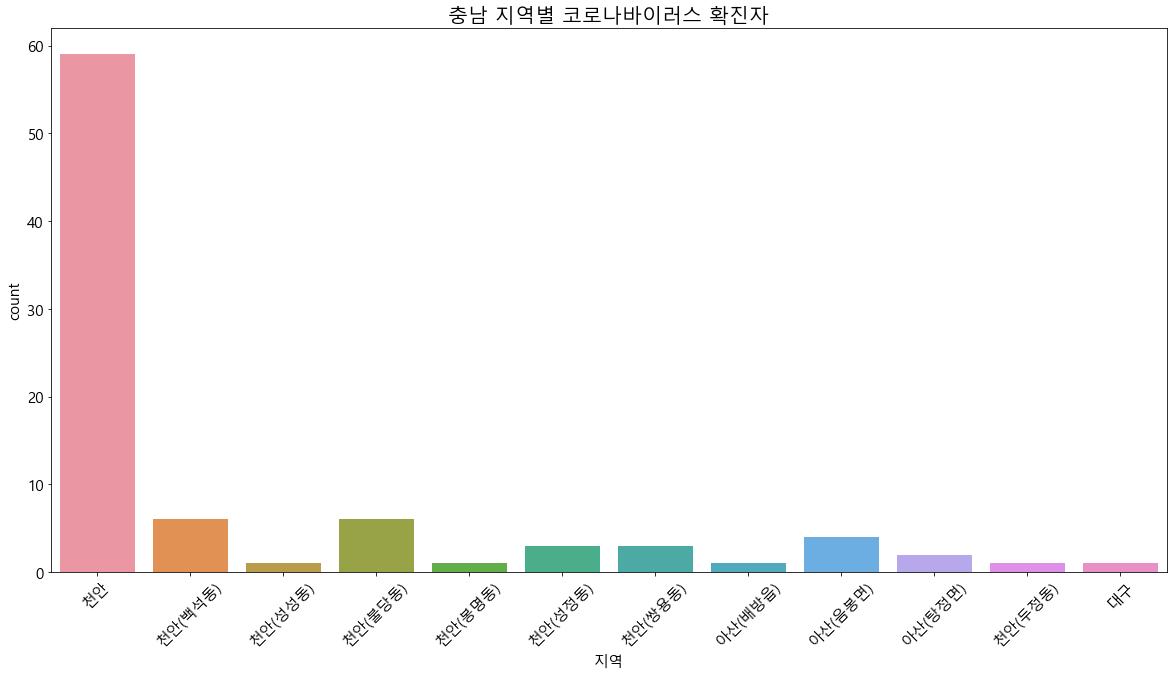

In [131]:
%matplotlib inline

plt.figure(figsize=(20,10))

plt.title('충남 지역별 코로나바이러스 확진자', fontsize=20)
plt.xticks(fontsize=15,rotation=45)
plt.yticks(fontsize=15)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
#plt.legend(fontsize=15)
sns.countplot(x=df["지역"],data=df)

In [115]:
# 확진일 시계열 변수로 변환
# 나이 연령대 추가
#df['나이']=df['나이'].str.replace('세','')#.astype(int)
#df['나이']=df['나이'].str.replace('대','')
df['나이']
df['연령대']=(df['나이']//10)*10
#df['연령대'].apply(lambda x:(df['나이']//10)*10)


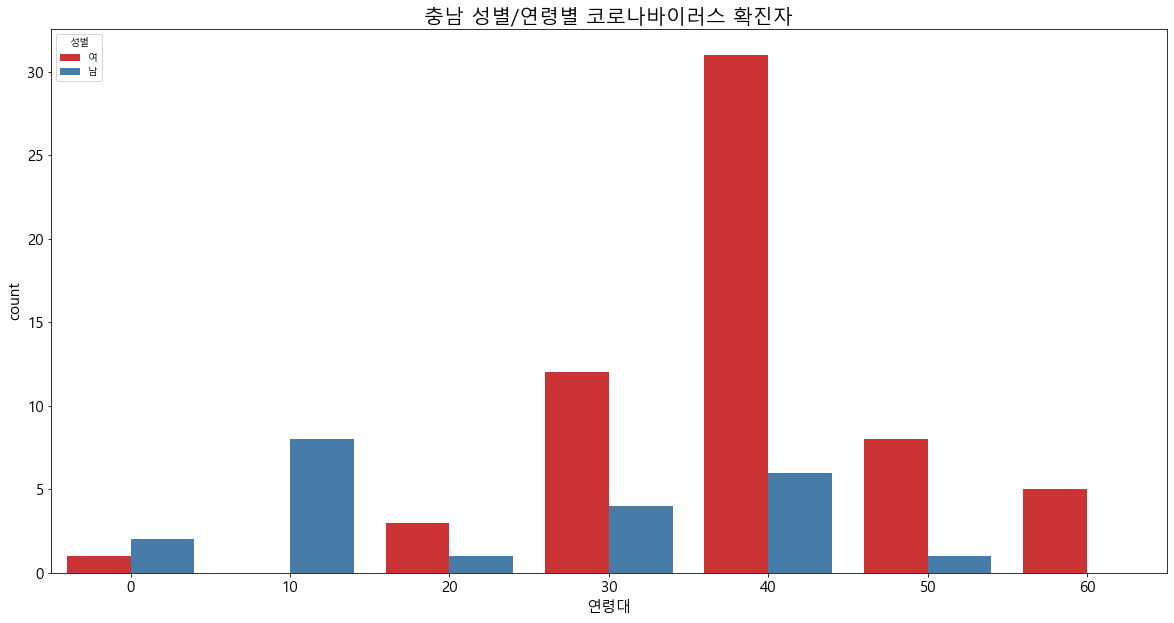

In [117]:
import seaborn as sns
plt.figure(figsize=(20,10))
plt.title('충남 성별/연령별 코로나바이러스 확진자', fontsize=20)
plt.xticks(fontsize=15,rotation=0)
plt.yticks(fontsize=15)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
sns.set_context(font_scale=15)
sns.set_color_codes(palette='bright')
sns.countplot(x=df["연령대"],hue='성별',data=df, palette='Set1')

In [121]:
splt=df['이동경로_편집'].tolist()

In [124]:
home,way=[],[]
for sp in splt:
    spp=sp.split('\n\n')
    home.append(spp[0])
    way.append(spp[1:])
print(home)
    

['\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5.(목) 확진 판정\n- 역학조사 中', '\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5.(목) 확진 판정\n- 역학조사 中', '\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5.(목) 확진 판정\n- 역학조사 中', '\n- 2.27.(목) 인후통, 가래 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.4.(수) 확진 판정\n- 역학조사 中', '\n- 2.25.(화) 인후통 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.4.(수) 확진 판정\n- 역학조사 中', '\n- 2. 24.(월) 기침, 가래 증상, 천안동남구보건소 선별진료소에서 검체 채취, 3.4. 확진 판정\n- 거주지 : 백석동 주공그린빌 1단지, 충남#6번(아산#1번) 확진자(대타강사 1회, 강습 50분)로부터 1회 수업 받음, 역학조사 中', '\n- 2. 24.(월) 코막힘,인후통 증상, 3.1.(일) 천안서북구보건소 선별진료소에서 검체 채취, 3.3.(화) 확진 판정\n- 거주지 : 천안백석푸르지오, 충남#8번(천안#5번) 확진자의 수강생, 역학조사 中', '\n- 2. 27.(목) 기침,가래, 인후통 증상, 3.1.(일) 천안서북구보건소 승차선별진료소에서 검체 채취, 3.3.(화) 확진 판정\n- 거주지 : 성성동 씨티자이, 천안 확진자와 연관성 조사 중, 역학조사 中(서울대정병원 역학조사)', '\n- 3.1.(일) 무증상, 3.1.(일) 천안서북구보건소 승차선별진료소에서 검체 체취, 3.2.(월) 확진 판정\n- 거주지 : 백석동 백석아이파크2차, 충남#74번(천안#66번) 확진자의 가족', '\n- 3.1.(일) 천안단국대병원 외부 선별진료소에서 검체 체취, 3.2.(월) 발열 증상, 3.2.(월) 확진 판정\n- 거주지 : 불당동 상가주택, 충남#76번(천안#68번) 확진자의 가족', '\n- 3.1.(일) 

In [125]:
df['증상_거주지']=home
df['경로']=way

In [126]:
df.head(5)

,환자,인적사항,감염경로,확진일,접촉자수,격리시설,이동경로,나이,지역,성별,대분류,소분류,이동경로_편집,증상_거주지,경로
0,충남#88(천안#80),"천안, 여, 6세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",6세,천안,여,충남#88,천안#80,"\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5...","\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5...",[\n]
1,충남#87(천안#79),"천안, 남, 12세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",12세,천안,남,충남#87,천안#79,"\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5...","\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5...",[\n]
2,충남#86(천안#78),"천안, 여, 39세",역학조사중,3월 5일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 3.4.(수) 기타 증상, 천...",39세,천안,여,충남#86,천안#78,"\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5...","\n- 3.4.(수) 기타 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3.5...",[\n]
3,충남#85(천안#77),"천안, 여, 48세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.27.(목) 인후통, 가래...",48세,천안,여,충남#85,천안#77,"\n- 2.27.(목) 인후통, 가래 증상, 천안서북구보건소 선별진료소에서 검체 체...","\n- 2.27.(목) 인후통, 가래 증상, 천안서북구보건소 선별진료소에서 검체 체...",[\n]
4,충남#84(천안#76),"천안, 남, 39세",역학조사중,3월 4일,역학조사중,확인중,"\n\t\t\t\t\t\t\t\t\t\t\t\t\t- 2.25.(화) 인후통 증상,...",39세,천안,남,충남#84,천안#76,"\n- 2.25.(화) 인후통 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3...","\n- 2.25.(화) 인후통 증상, 천안서북구보건소 선별진료소에서 검체 체취, 3...",[\n]


In [127]:
df.to_csv('천안코로나.csv',encoding='utf-8-sig')